# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

Перед нами таблица, в которой почти 24 тысячи строк с данными об объявлениях, в ней 22 столбца с преимущественно числовыми значениями. Даже беглый вгляд на таблицу позволяет сказать, что некоторые колонки имеют пропуски, что подтвреждается выводом общей информации о данных.
Рассмотрим, какую информацию содержат столбцы:
* total_images — число фотографий квартиры в объявлении;
* last_price — цена на момент снятия с публикации;
* total_area — площадь квартиры в квадратных метрах (м²);
* first_day_exposition — дата публикации;
* rooms — число комнат;
* ceiling_height — высота потолков (м);
* floors_total — всего этажей в доме;
* living_area — жилая площадь в квадратных метрах(м²);
* floor — этаж;
* is_apartment — апартаменты (булев тип);
* studio — квартира-студия (булев тип);
* open_plan — свободная планировка (булев тип);
* kitchen_area — площадь кухни в квадратных метрах (м²);
* balcony — число балконов;
* locality_name — название населённого пункта;
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м);
* cityCenters_nearest — расстояние до центра города (м);
* parks_around3000 — число парков в радиусе 3 км;
* parks_nearest — расстояние до ближайшего парка (м);
* ponds_around3000 — число водоёмов в радиусе 3 км;
* ponds_nearest — расстояние до ближайшего водоёма (м);
* days_exposition — сколько дней было размещено объявление (от публикации до снятия).

### Шаг 2. Предобработка данных

Для начала проверим наши данные на наличе дубликатов, чтобы сразу от них избавиться и не возвращаться к ним.

In [ ]:
data.duplicated().sum()

0

Дублей в нашй таблице не обнаружено, что хорошо. Теперь мы можем переходить к обработке пропусков.

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Некоторые переменные мы можем оставить с пропусками, например общее *количество этажей*. Дома могут быть разные по этажности и высчитывать какое-то среднее значение для заполнения пропусков тут неуместно. Пропуски в столбце *is_apartment* составляют почти 90%! Они возникли, вероятно, потому, что пользователь просто не указал эту информацию. На наше исследование эти пропуски не повлияют.

Также мы оставим с пропусками столбцы с расстояниями и количеством парков и водоёмов. Тут, видимо, произошла техническая ошибка, поскольку эти данные должны были заполниться автоматически. Нужно сообщить об этом в технический отдел. Более трёх тысяч пустых строк в столбце *days_exposition* это тоже скорее техническая ошибка. Заменить чем-то пустые строки не представляется возможным без искажения наших данных, оставим так, как есть.
В колонке с количеством балконов пропуски потому, что в квартире нет балкона, заменим пропуски на 0.

In [ ]:
data['balcony'] = data['balcony'].fillna(0)

В нашем датафрейме пропущено почти 40% данных по высоте потолков. Это очень много. Высота потолков, как правило зависит от дома. В типичной пятиэтажке потолки будут примерно такие же, как и в другой пятиэтажке. Чтобы не терять данные, сгруппируем таблицу по количеству этажей и найдём медианные значения высоты потолков.

In [ ]:
data[data['days_exposition'].isna()].head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,NaN,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.30,7,NaN,False,False,7.0,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.70,9,NaN,False,False,8.3,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN
49,1,3050000.0,30.8,2018-11-22T00:00:00,1,2.50,9.0,18.00,7,NaN,False,False,6.0,0.0,Санкт-Петербург,45341.0,16603.0,1.0,675.0,0.0,NaN,NaN
52,20,11795000.0,136.0,2017-09-22T00:00:00,6,3.00,2.0,94.00,2,NaN,False,False,11.0,1.0,Санкт-Петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN
71,20,4850000.0,57.5,2019-03-27T00:00:00,3,2.50,9.0,39.00,8,NaN,False,False,6.2,0.0,Санкт-Петербург,33623.0,12267.0,1.0,334.0,1.0,333.0,NaN
81,9,10949000.0,68.0,2018-12-27T00:00:00,1,NaN,10.0,NaN,6,NaN,False,False,NaN,0.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,11,2400000.0,43.9,2019-03-13T00:00:00,2,NaN,2.0,27.46,1,NaN,False,False,5.2,0.0,Кировск,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
median_floor = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['count', 'median'])
median_floor.columns = ['count', 'ceiling_height']
median_floor

,count,ceiling_height
floors_total,,
1.0,10,2.80
2.0,215,2.70
3.0,399,2.80
4.0,789,3.00
5.0,3666,2.55
6.0,619,3.00
7.0,398,3.00
8.0,220,2.80
9.0,2557,2.55


Как мы видим, определённой зависимости нет, поэтому мы не можем просто так заменить пустые строки на среднее значение. Посмотрим, например, на пятиэтажки.

In [ ]:
data.query('floors_total == 5.0').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
11,9,3300000.0,44.0,2018-08-27T00:00:00,2,NaN,5.0,31.0,4,False,False,False,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
12,10,3890000.0,54.0,2016-06-30T00:00:00,2,NaN,5.0,30.0,5,NaN,False,False,9.0,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
13,20,3550000.0,42.8,2017-07-01T00:00:00,2,2.56,5.0,27.0,5,NaN,False,False,5.2,1.0,Петергоф,37868.0,33058.0,1.0,294.0,3.0,298.0,366.0
16,11,6700000.0,82.0,2017-11-23T00:00:00,3,3.05,5.0,55.6,1,NaN,False,False,9.0,0.0,Санкт-Петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0
18,8,3250000.0,31.0,2017-01-27T00:00:00,1,2.50,5.0,19.4,2,NaN,False,False,5.6,1.0,Санкт-Петербург,44060.0,10842.0,1.0,759.0,0.0,NaN,168.0
21,13,3200000.0,31.6,2018-03-14T00:00:00,1,NaN,5.0,16.9,2,NaN,False,False,5.7,1.0,Санкт-Петербург,36064.0,9722.0,1.0,248.0,0.0,NaN,310.0
26,6,4050000.0,60.0,2017-04-28T00:00:00,4,NaN,5.0,43.0,4,NaN,False,False,7.0,0.0,Санкт-Петербург,11580.0,10510.0,0.0,NaN,1.0,95.0,265.0
32,7,4990000.0,60.0,2016-05-22T00:00:00,3,NaN,5.0,39.0,4,NaN,False,False,6.0,0.0,Санкт-Петербург,11349.0,12889.0,0.0,NaN,1.0,426.0,224.0
35,6,15500000.0,149.0,2017-06-26T00:00:00,5,NaN,5.0,104.0,4,NaN,False,False,17.0,0.0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0


Видно, что встречаются потолки как 2.5 так и 3 метра высотой. Значит наша гипотеза не подтвердилась. Придётся оставить пустые значения.

У нас имеется 49 пропущенных названий населённых пунктов. Попробуем разобраться с ними. Возможно это всё Санкт-Петербург. Выберем все строки с Санкт-Петербургом, посмотрим на удаление от центра и сравним со строками с пустыми значениями.

In [ ]:
city_spb = data.query('locality_name == "Санкт-Петербург"')
city_spb.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9.0,43.6,7,NaN,False,False,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
10,5,5050000.0,39.6,2017-11-16T00:00:00,1,2.67,12.0,20.3,3,NaN,False,False,8.5,0.0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0
15,16,4650000.0,39.0,2017-11-18T00:00:00,1,NaN,14.0,20.5,5,NaN,False,False,7.6,1.0,Санкт-Петербург,12900.0,14259.0,1.0,590.0,1.0,296.0,19.0
16,11,6700000.0,82.0,2017-11-23T00:00:00,3,3.05,5.0,55.6,1,NaN,False,False,9.0,0.0,Санкт-Петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0
17,6,4180000.0,36.0,2016-09-09T00:00:00,1,NaN,17.0,16.5,7,NaN,False,False,11.0,1.0,Санкт-Петербург,33564.0,14616.0,0.0,NaN,1.0,859.0,571.0


In [ ]:
city_spb['cityCenters_nearest'].max()

29493.0

Максимальное удаление от центра города почти 30 километров, а значит всё, что меньше этой цифры, можно назвать Санкт-Петербургом.

In [ ]:
city_null = data[data['locality_name'].isnull()]
city_null

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.80,2,NaN,False,False,8.80,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,NaN,4.0,42.60,2,NaN,False,False,18.60,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,NaN,24.0,15.60,3,NaN,False,False,10.70,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,NaN,24.0,33.10,21,NaN,False,False,8.20,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,NaN,5.0,30.80,5,NaN,False,False,6.50,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.62,7,NaN,False,False,13.38,0.0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.30,3,False,False,False,10.40,0.0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,NaN,7.0,NaN,6,NaN,False,False,NaN,0.0,NaN,26534.0,5382.0,1.0,446.0,1.0,376.0,350.0
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,NaN,7.0,59.10,5,False,False,False,8.30,4.0,NaN,10556.0,9538.0,1.0,67.0,0.0,NaN,303.0
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,NaN,24.0,20.00,23,NaN,False,False,NaN,0.0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0


Кроме трёх строк все остальные значения лежат в пределах нужной нам удалённости, значит мы смело можем присвоить всем пропускам значение *Санкт-Петербург*.

In [ ]:
data['locality_name'] = data['locality_name'].fillna('Санкт-Петербург')

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Итак, у нас остались пустые значения в столбцах *living_area* и *kitchen_area*, хоть их и не более 10% от общей массы данных, их мы не можем выкинуть просто так, да и есть квартиры-студии, у которых нет отдельного помещения для кухни. Эти данные придётся оставить как есть.

Перейдём от борьбы с пропусками к типам данных. В нашей таблице некоторые данные отображены вещественным числом, хоть правильнее будет целое, ведь не может же быть половинки этажа, половины балкона или 2,5 пруда возле дома. Поскольку у нас есть пропуски, то будем использовать *astype('Int64')*. Также поправим отображение даты.

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], yearfirst=True)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [ ]:
for column in data:
    if column == 'floors_total' or column == 'balcony' or column == 'parks_around3000' or column == 'ponds_around3000' or column == 'days_exposition':
        data[column] = data[column].round().astype('Int64')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121


# Вывод
Итак, мы, где смогли избавились от пропусков, проверили данные на дубликаты и заменили типы данных там, где это было необходимо. Мы подготовили таблицу для дальнейшего исследования.

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим в наше исследование ещё немного данных. Для начала посчитаем цену за квадратный метр. Для этого разделим стоимость квартиры на её общую площадь.

In [ ]:
data['price_per_meter'] = data['last_price'] / data['total_area']
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000


Посмотрим на новые данные подробнее.

In [ ]:
data['price_per_meter'].describe()

count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: price_per_meter, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Гистограмма распределения цен за квадратный метр')

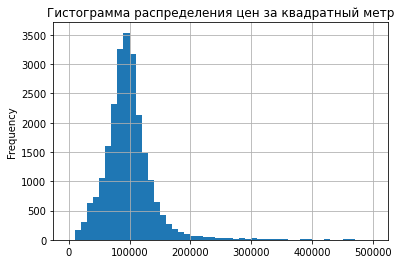

In [ ]:
(data['price_per_meter']
 .plot(kind='hist', bins=50, range=(0, 500000)
       , grid=True))
plt.title('Гистограмма распределения цен за квадратный метр')

По описанию столбца и графику мы можем сказать, что минмальная цена за квадратный метр чуть больше 100 рублей, что странно, а максимум - почти 2 миллиона! В среднем же цена за квадратный метр около 100 тысяч рублей.

Теперь добавим новые колонки с днём недели, месяцем и годом, когда было размещено объявление.

In [ ]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370.370370,3,3,2019
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,NaN,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,<NA>,72490.845228,1,3,2017
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.0,4,NaN,False,False,8.50,0,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,45,52542.372881,0,1,2018
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.7,1,NaN,False,False,NaN,0,село Рождествено,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,44091.710758,6,2,2018
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,NaN,12,NaN,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602,149511.400651,1,3,2017


Внесём ещё *floor_group* в таблицу, сгруппировав данные по этажам, выделим три группы: первый этаж, последний этаж и другой.

In [ ]:
def floor_group(floor):
    if floor == 1:
        return 'первый'
    else:
        return 'другой'
        
data['floor_group'] = data['floor'].apply(floor_group)

In [ ]:
data.loc[data['floor'] == data['floors_total'], 'floor_group'] = 'последний'
data['floor_group'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

Также добавим значение соотношения жилой площади и площади кухни к общей площади квартир, введём параметры *living_area_to_total* и *kitchen_area_to_total*.

In [ ]:
data['living_area_to_total'] = data['living_area'] / data['total_area']
data['kitchen_area_to_total'] = data['kitchen_area'] / data['total_area']
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,NaN,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,<NA>,72490.845228,1,3,2017,другой,0.547792,0.103356
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.0,4,NaN,False,False,8.50,0,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,45,52542.372881,0,1,2018,другой,0.644068,0.144068
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.7,1,NaN,False,False,NaN,0,село Рождествено,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>,44091.710758,6,2,2018,первый,0.523810,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,NaN,12,NaN,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602,149511.400651,1,3,2017,другой,NaN,0.303583


# Вывод
Мы добавили к нашим данным об объявления о продаже квартир ещё несколько важных значений, напрмер цену за квадратный метр, дни недели подачи объявления, соотношение площадей комнат к общей площади квартиры. Всё это поможет нам точнее ответить на поставленные задачи

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Посмотрим каково распределение цены, площади, количества комнат, высоты потолков и дней количества дней продажи квартуры, построим гистограммы.

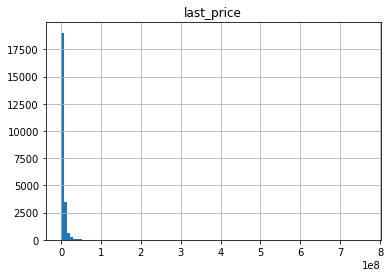

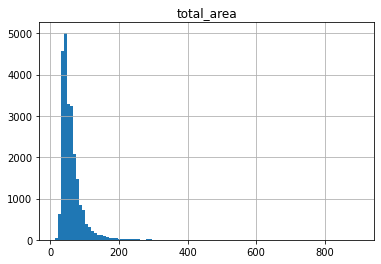

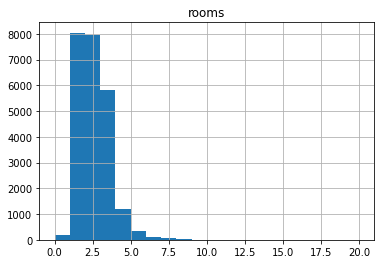

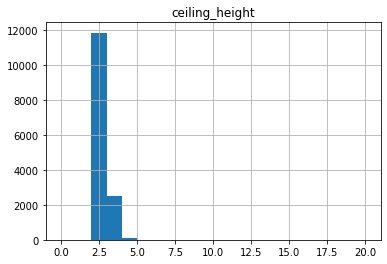

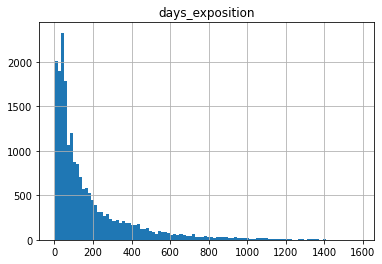

In [ ]:
for column in data:
    if column == 'last_price' or column == 'total_area' or column == 'days_exposition':
        data.hist(column=column, grid=True, bins=100)
    if column == 'rooms' or column == 'ceiling_height':
        data.hist(column=column, grid=True, bins=20, range=(0, 20))

По такому графику  с ценой мало что понятно. Есть пик около 0, но при таким масшатебе сложно понять каие там средние значения. Также имеется длинный хвост, который также не даёт ответа сколько там значений. Посмотрим описание данной переменной.

In [ ]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Средняя стоимость квартиры около 6,5 миллионов, что в целом не вызывает вопросов, однако медиана равна 4,65 млн. А вот минимальная цена - 12 тысяч! Это подозрительно дёшево. Максимум же во сколько оценили жильё - это 763 миллиона. Результат не удивительный, но если посмотреть, что 75% квартир стоят менее 6,8 миллионов, то такое значение будет искажать наши результаты исследований, вытягивать среднее наверх. Укрупним диапазон и расмотрим данные в разрезе от 0 до 50 млн.

Text(0.5, 1.0, 'Гистограмма распределения цен за квартиру')

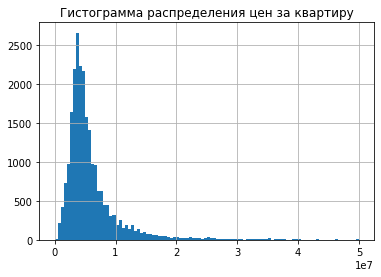

In [ ]:
data.hist(column='last_price', grid=True, bins=100, range=(0, 50000000))
plt.title('Гистограмма распределения цен за квартиру')

В целом мы видим распределение Пуассона с один ярко выраженными пиком в районе 3-5 миллионов, что в целом близко к медианному значению.

Теперь построим гистограмму по данным с площадью квартир.

На гистограмме с данными о площади мы видим также один пик и очень длинный хвост графика, что соответствует пуассоновскому распределению. Посмотрим описание.

In [ ]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

Вот и причина очень длинного хвоста - максимальная площадь квартиры равна 900 квадратным метрам, это при том, что 75% всех данных уклатывается в 70 квадратных метров. Также как и с предыдущей переменой взглянем на график подробнее, в диапазоне до 300 метров.

Text(0.5, 1.0, 'Гистограмма распределения площади квартир')

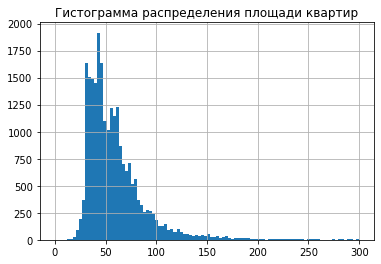

In [ ]:
data.hist(column='total_area', grid=True, bins=100, range=(0, 300))
plt.title('Гистограмма распределения площади квартир')

На дам графике выделяется небольшой пик около 60 квадратных метров, видимо на рынке недвижимости таких квартир представлено чуть больше, чем квартиир с площадью 50-55 метров. А преобладают в объявлениях квартиры с площадью в 40 метров квадратных.

Изучим гистограмму по количеству комнат. Как мы можем судить из графика и описания данных, продают больше всего квартир одно- и двухкомнатных, остальных значительно меньше. Посмотрим описание столбца.

In [ ]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Удивляет, что есть квартиры с 0 комнат, а максимум - 19!

Теперь посмотрим, что там с высотой потолков. Мы уже знаем, что эти данные неполные и у нас есть большое количество пропусков.

In [ ]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

По высоте потолков не такое большое разнообразие, основная масса значений расположилась на значении 2,5 метра, хотя среднее и медианное значение почти равны. Вероятно из-за выдающегося значения в 100 метров, среднее немного сместилось. Смущает также минимальная высота потолка в 1 метр.

Посмотрим на время продажи квартиры.

In [ ]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

В целом большая часть квартир продаётся быстро. Половина квартир продаётся в течение 95 дней. При этом пик на графике говорит нам о том, что больше всего квартир было продано в первые 50 дней. Среднее же значение равно 180 дням, относительно медианы, это в два раза больше! Видимо хвост графика тянет среднее вверх. Не удивительно, ведь кто-то смог продать жильё спустя 1580 дней, а это более четырёх лет! Взглянем на хвост подробнее.

In [ ]:
data[data['days_exposition'] > 1500]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
1109,1,34878556.0,95.80,2014-12-09,2,NaN,6,58.30,5,True,False,False,20.00,1,Санкт-Петербург,21860.0,318.0,2,160.0,3,569.0,1572,364076.784969,1,12,2014,другой,0.608559,0.208768
1885,2,13300000.0,79.60,2014-12-09,2,3.00,8,42.70,7,NaN,False,False,18.00,0,Санкт-Петербург,39393.0,11096.0,1,537.0,0,NaN,1513,167085.427136,1,12,2014,другой,0.536432,0.226131
6691,3,4400000.0,42.98,2014-12-12,1,NaN,5,18.72,1,NaN,False,False,11.31,0,Пушкин,19715.0,30358.0,1,439.0,3,232.0,1512,102373.196836,4,12,2014,первый,0.435551,0.263146
9553,11,10600000.0,80.00,2014-12-09,3,2.85,17,44.00,9,NaN,False,False,15.00,0,Санкт-Петербург,17101.0,17110.0,0,NaN,0,NaN,1553,132500.000000,1,12,2014,другой,0.550000,0.187500
18843,11,3500000.0,48.20,2014-12-15,2,2.50,5,27.40,2,NaN,False,False,7.70,3,деревня Новое Девяткино,NaN,NaN,<NA>,NaN,<NA>,NaN,1580,72614.107884,0,12,2014,другой,0.568465,0.159751
20969,18,13300000.0,133.00,2015-02-11,4,3.00,5,58.00,2,NaN,False,False,45.00,0,Санкт-Петербург,24653.0,5032.0,0,NaN,1,534.0,1512,100000.000000,2,2,2015,другой,0.436090,0.338346


Объединяет неудачных продавцов то, что выставлялись объявления о продаже в конце 2014 - начале 2015 годов, в момент после обвала рубля. А теперь посмотрим на быструю продажу в течение двух дней.

In [ ]:
data[data['days_exposition'] <= 2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
1632,19,4000000.0,49.9,2019-05-01,2,2.5,9,25.0,1,NaN,False,False,10.0,0,Санкт-Петербург,13567.0,14384.0,1,20.0,1,681.0,1,80160.320641,2,5,2019,первый,0.501002,0.200401
13061,20,6100000.0,51.4,2019-04-29,2,3.0,5,31.7,4,NaN,False,False,6.9,1,Санкт-Петербург,10776.0,9389.0,0,NaN,0,NaN,2,118677.042802,0,4,2019,другой,0.616732,0.134241
16053,4,4070000.0,45.1,2019-04-30,2,NaN,5,22.7,3,NaN,False,False,6.6,0,Санкт-Петербург,40859.0,11668.0,2,485.0,0,NaN,2,90243.902439,1,4,2019,другой,0.503326,0.146341
16212,0,7806000.0,25.0,2019-04-30,1,3.0,5,NaN,5,False,False,False,NaN,0,Санкт-Петербург,36525.0,10302.0,0,NaN,0,NaN,2,312240.000000,1,4,2019,последний,NaN,NaN


Сделки были совершены примерно в одно время в конце апреля - начале мая 2019 года.

Взглянем подробнее на выдающиеся значения по этим данным.

In [ ]:
data.query('total_area < 15')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
17961,3,1400000.0,13.0,2017-12-03,1,2.60,9,NaN,1,NaN,False,False,NaN,0,Санкт-Петербург,14350.0,15945.0,0,NaN,1,185.0,410,107692.307692,6,12,2017,первый,NaN,NaN
19546,3,1850000.0,13.0,2019-03-11,1,3.40,5,NaN,2,False,False,False,NaN,0,Санкт-Петербург,24915.0,5483.0,1,644.0,0,NaN,24,142307.692308,0,3,2019,другой,NaN,NaN
19558,2,1686000.0,13.2,2018-12-17,1,NaN,5,NaN,1,NaN,False,False,NaN,0,Санкт-Петербург,19891.0,4165.0,1,361.0,1,155.0,19,127727.272727,0,12,2018,первый,NaN,NaN
19642,5,1190000.0,14.0,2018-07-29,1,NaN,5,11.0,1,NaN,False,False,2.0,0,Санкт-Петербург,9898.0,11122.0,0,NaN,0,NaN,4,85000.000000,6,7,2018,первый,0.785714,0.142857
19807,0,3800000.0,13.0,2018-07-04,1,NaN,5,10.0,3,NaN,False,False,NaN,0,Санкт-Петербург,21302.0,1242.0,1,592.0,3,27.0,9,292307.692308,2,7,2018,другой,0.769231,NaN
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5,10.0,2,NaN,False,False,NaN,0,Санкт-Петербург,21314.0,964.0,1,886.0,2,45.0,200,200000.000000,2,7,2017,другой,0.833333,NaN


In [ ]:
data.query('total_area > 500')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5,NaN,5,NaN,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,<NA>,221870.047544,5,3,2019,последний,NaN,0.095087
4237,1,50000000.0,517.0,2017-10-14,7,NaN,4,332.0,3,NaN,False,False,22.0,0,Санкт-Петербург,22835.0,1847.0,2,477.0,2,540.0,<NA>,96711.798839,5,10,2017,другой,0.642166,0.042553
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.0,3,NaN,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14,110169.491525,3,2,2019,другой,0.693220,0.169492
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7,301.5,7,True,False,False,45.5,1,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,1078,165680.473373,3,12,2015,последний,0.594675,0.089744
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4,322.3,4,NaN,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,<NA>,221799.746515,1,4,2019,последний,0.510615,0.030894
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7,258.0,5,NaN,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111,485436.893204,0,12,2017,другой,0.417476,0.113269
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,NaN,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106,466666.666667,2,12,2017,последний,0.455222,0.124444


Как видим, что самые маленькие квартиры по площади, что самые большие, не являются ошибкой, а действительно существуют.

In [ ]:
data.query('last_price < 50000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,NaN,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8,111.834862,2,3,2019,последний,0.293578,0.37156


In [ ]:
data.query('last_price > 200000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.0,5,NaN,False,False,40.0,0,Санкт-Петербург,23011.0,1197.0,3,519.0,3,285.0,233,1.736842e+06,2,4,2018,другой,0.500000,0.210526
5893,3,230000000.0,500.0,2017-05-31,6,NaN,7,NaN,7,NaN,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,50,4.600000e+05,2,5,2017,последний,NaN,0.080000
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10,250.0,10,NaN,False,False,NaN,2,Санкт-Петербург,25108.0,3956.0,1,530.0,3,756.0,33,1.907500e+06,5,9,2017,последний,0.625000,NaN
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7,218.0,7,NaN,False,False,40.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,199,5.853659e+05,5,4,2017,последний,0.531707,0.097561
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9,204.0,9,False,False,False,24.0,3,Санкт-Петербург,21912.0,2389.0,1,545.0,1,478.0,393,1.000748e+06,5,2,2016,последний,0.508728,0.059850
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7,258.0,5,NaN,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111,4.854369e+05,0,12,2017,другой,0.417476,0.113269
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7,182.8,4,NaN,False,False,29.8,0,Санкт-Петербург,33143.0,6235.0,3,400.0,3,140.0,249,8.575429e+05,0,4,2017,другой,0.639832,0.104305
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,NaN,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106,4.666667e+05,2,12,2017,последний,0.455222,0.124444
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6,63.7,6,NaN,False,False,30.2,0,Санкт-Петербург,22494.0,1073.0,3,386.0,3,188.0,<NA>,1.542605e+06,1,3,2019,последний,0.339733,0.161067


С ценой тоже всё нормально, кроме самого маленького значения. Вероятно произошла ошибка при подаче объявления и цену указали не в рублях, а в тысячах рублей, тем самым потеряв три ноля.

Однако мы не будем исправлять единственное значение. Мы просто отбросим все крайние значения, чтобы не было заметного перекоса в ту или иную сторону. Уберём все строки, где цена менее 50000 и более 200000000 за квадратный метр и площадь более 500 квадратных метров, сохраним все это в новый датафрейм *good_data*.

In [ ]:
good_data = data.query("(50000 < last_price < 200000000) and (total_area < 500)").copy()
good_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000


Теперь посмотрим на количество комнат, мы уже знаем, что есть 0 комнат, а сколько квартир с количеством комнат больше 10?

In [ ]:
good_data.query('rooms > 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
648,3,17500000.0,183.7,2018-07-01,11,3.40,7,138.8,7,NaN,False,False,13.3,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,<NA>,95264.017420,6,7,2018,последний,0.755580,0.072401
866,5,25000000.0,363.0,2017-12-23,14,3.16,5,222.0,4,NaN,False,False,16.6,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418,68870.523416,5,12,2017,другой,0.611570,0.045730
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5,129.0,2,NaN,False,False,11.9,0,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813,170015.455951,1,2,2017,другой,0.664606,0.061309
14498,6,32250000.0,374.6,2018-06-09,19,NaN,5,264.5,2,NaN,False,False,27.6,0,Санкт-Петербург,19497.0,3574.0,0,NaN,2,548.0,114,86091.831287,5,6,2018,другой,0.706086,0.073679
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4,180.0,4,NaN,False,False,13.0,1,Санкт-Петербург,23575.0,4142.0,1,516.0,0,NaN,1365,105555.555556,0,3,2015,последний,0.666667,0.048148
20829,6,28659000.0,245.4,2016-03-31,14,NaN,4,168.3,2,NaN,False,False,25.9,0,Санкт-Петербург,21104.0,2054.0,3,541.0,2,118.0,95,116784.841076,3,3,2016,другой,0.685819,0.105542


Избавимся от них в нашей новой таблице.

In [ ]:
good_data = good_data.query('10 > rooms and rooms != 0')

Тепрь взглянем на высоту потолков.

In [ ]:
good_data.query('ceiling_height > 50')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19,600000.0,2,7,2018,последний,0.56,0.44


In [ ]:
good_data.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2,27.5,1,NaN,False,False,5.20,0,городской посёлок Мга,NaN,NaN,<NA>,NaN,<NA>,NaN,248,35046.728972,0,8,2017,первый,0.642523,0.121495
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37,17.4,5,NaN,False,False,8.34,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,71,102500.000000,1,10,2017,другой,0.435000,0.208500
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12,32.4,7,NaN,False,False,10.00,0,Санкт-Петербург,33053.0,14217.0,2,293.0,2,289.0,13,109090.909091,2,10,2018,другой,0.589091,0.181818


Мы обнаружили странные значения, есть одна квартира высотой в 100 метров и три квартиры с высотой потолков меньше среднего человеческого роста, явно это какая-то ошибка в данных. Уберём и их из наших данных.

In [ ]:
good_data = good_data.query("(2 <= ceiling_height < 50) or (ceiling_height != ceiling_height)")

Отсечём также объявления которые продержались более 1100 дней, что соответствует 3 годам.

In [ ]:
good_data = good_data[good_data['days_exposition']<1100]
good_data.reset_index()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total
0,1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018,первый,0.460396,0.272277
1,2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214
2,3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN
3,4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000
4,5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.4,5,NaN,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,<NA>,NaN,<NA>,NaN,55,95065.789474,0,9,2018,другой,0.473684,0.299342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20144,23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,NaN,False,False,10.6,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519,129903.978052,3,10,2016,другой,0.552812,0.145405
20145,23692,2,1350000.0,30.00,2017-07-07,1,NaN,5,17.5,4,NaN,False,False,6.0,0,Тихвин,NaN,NaN,<NA>,NaN,<NA>,NaN,413,45000.000000,4,7,2017,другой,0.583333,0.200000
20146,23693,9,4600000.0,62.40,2016-08-05,3,2.60,9,40.0,8,NaN,False,False,8.0,0,Петергоф,45602.0,34104.0,1,352.0,1,675.0,239,73717.948718,4,8,2016,другой,0.641026,0.128205
20147,23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.0,4,NaN,False,False,8.5,0,Тосно,NaN,NaN,<NA>,NaN,<NA>,NaN,45,52542.372881,0,1,2018,другой,0.644068,0.144068


# Вывод
Итак, мы подготовили наши данные для последующего исследования, избавились от выдающихся значений и хвостов, да к тому же с минимальной потерей данных.

### Какие факторы больше всего влияют на стоимость квартиры?

Теперь посмотрим на зависимость цены и площади по нашему срезу на графике.

Text(0.5, 1.0, 'Зависимость цены квартиры от её площади')

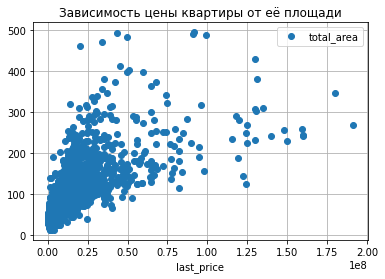

In [ ]:
good_data.plot(x='last_price', y='total_area', style='o', grid=True)
plt.title('Зависимость цены квартиры от её площади')

In [ ]:
good_data['last_price'].corr(good_data['total_area'])

0.7208078507549363

На графике видно, что зависимость между ценой и площадью существует. С увеличением площади, увеличивается и цена на квартиру. До 100 квадратных метров зависимость линейная, после 100 метров, график поднимается медленнее. Да и коэффициет кореляции между переменными достаточно высокий - 0,7.

Проверим, как зависит цена квартиры от количества комнат.

Text(0.5, 1.0, 'Зависимость цены квартиры от количества комнат\n')

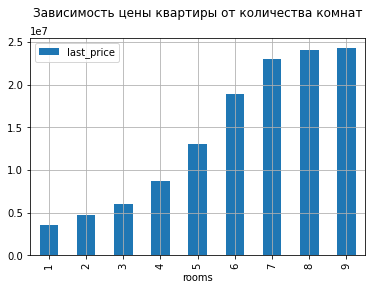

In [ ]:
good_data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от количества комнат\n')

In [ ]:
good_data['last_price'].corr(good_data['rooms'])

0.42702196993775526

В соотношении между ценой квартиры и количеством комнат, тоже прослеживается зависимость. В среднем, чем больше комнат в квартире, тем цена на неё выше. А после семи комнат соотношение их количества к средней цене за жильё не меняется. Коэффициент кореляции невысокий, всего 0,4.

Теперь определим, как меняется стоимость жилья в зависимости от удаления от центра города.

Text(0.5, 1.0, 'Зависимость цены квартиры от удалённости от центра')

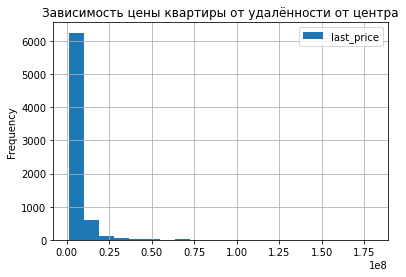

In [ ]:
good_data.pivot_table(index='cityCenters_nearest', values='last_price', aggfunc='median').plot(kind='hist', bins=20, grid=True)
plt.title('Зависимость цены квартиры от удалённости от центра')

По такому графику мало что понятно, видно лишь то, что чем ближе к центру, тем выше цена. Разобъём наши данные на группы по удалённости от центра и посмотрим подробнее, как меняется средняя цена жилплощади.

In [ ]:
good_data['cityCenters_nearest_group'] = pd.cut(good_data['cityCenters_nearest'],[0,1000,2000,5000,10000,20000,50000,100000])

In [ ]:
good_data.pivot_table(index='cityCenters_nearest_group', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
cityCenters_nearest_group,,
"(0, 1000]",10900000.0,69
"(1000, 2000]",10325000.0,194
"(2000, 5000]",8950000.0,1415
"(5000, 10000]",6740000.0,2521
"(10000, 20000]",4750000.0,9110
"(20000, 50000]",4000000.0,2127
"(50000, 100000]",3500000.0,155


Text(0.5, 1.0, 'Зависимость цены квартиры от удалённости от центра\n')

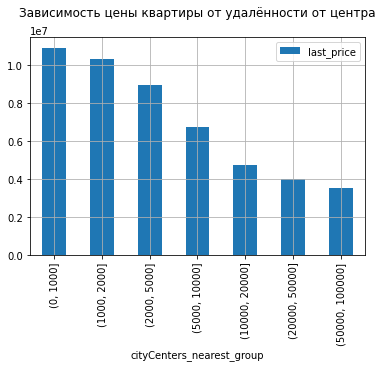

In [ ]:
good_data.pivot_table(index='cityCenters_nearest_group', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от удалённости от центра\n')

Теперь мы видим, что средняя цена за квартиру в пешей доступности от центра более 10 миллионов и, чем дальше, цем средний ценник меньше. Так квартиры в удалении 5-10 км от центра стоят в среднем почти в два раза дешевле - 7 миллионов, а в удалении 15-20 км уже 5 миллионов. Ну и на удалении более 50 км от центра нет квартир дороже 4 миллионов.

Как зависит цена на жильё в зависимости от этажа? Не все хотят жить на первом или последнем этаже. Мы посмотрим влияет ли это на цену.

In [ ]:
good_data.pivot_table(index='floor_group', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
floor_group,,
другой,4700000.0,14942
первый,3850000.0,2412
последний,4243000.0,2795


Text(0.5, 1.0, 'Зависимость цены квартиры от этажа\n')

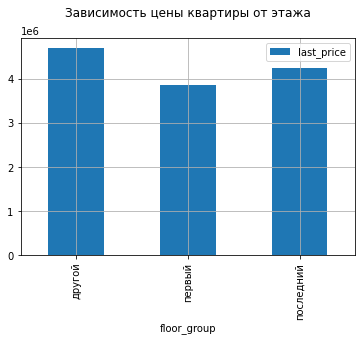

In [ ]:
good_data.pivot_table(index='floor_group', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа\n')

Как мы можем видеть по сводной таблице, наша гипотеза подтвердилась, количество объявлений о продаже квартир на первом и последнем этаже в сумме в три раза меньше, чем квартир на другом этаже, да и средняя цена на квартиры на другом этаже выше.

Теперь мы посмотрим, когда больше всего было подано объявлений, в какой день недели, месяц и год и есть ли зависимость между эти факторами и ценой.

In [ ]:
good_data.pivot_table(index='weekday', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
weekday,,
0,4500000.0,3000
1,4600000.0,3544
2,4550000.0,3346
3,4562500.0,3694
4,4500000.0,3463
5,4500000.0,1647
6,4480000.0,1455


Text(0.5, 1.0, 'Зависимость цены квартиры от дня подачи объявления')

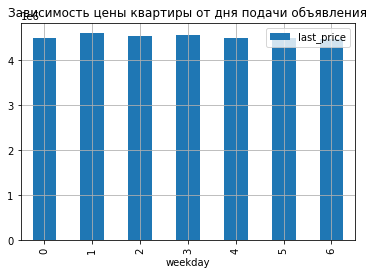

In [ ]:
good_data.pivot_table(index='weekday', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от дня подачи объявления')

День недели никак не влияет на цену, в среднем цена по каждому дню 4,6 миллиона за жилплощадь. Единственное меняется количество объявлений, в выходные дних их в 2 раза меньше, чем в будни.

In [ ]:
good_data.pivot_table(index='month', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
month,,
1,4500000.0,1266
2,4550000.0,2247
3,4500000.0,1930
4,4580000.0,1505
5,4500000.0,1141
6,4370000.0,1670
7,4550000.0,1551
8,4500000.0,1585


Text(0.5, 1.0, 'Зависимость цены квартиры от месяца подачи объявления')

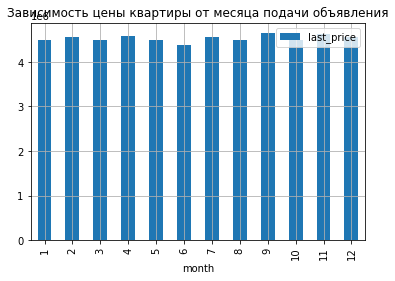

In [ ]:
good_data.pivot_table(index='month', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от месяца подачи объявления')

Месяц также мало влияет не среднюю цену жилплощади, разница между самой высокой ценой в апреле и самой низкой - в июне составляет 400 тысяч. Количество объявлений уменьшается в период отпусков и на новогодние каникулы.

In [ ]:
good_data.pivot_table(index='year', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
year,,
2014,6800000.0,87
2015,5100000.0,994
2016,4500000.0,2700
2017,4500000.0,7810
2018,4500000.0,7485
2019,4799500.0,1073


Text(0.5, 1.0, 'Зависимость цены квартиры от года подачи объявления')

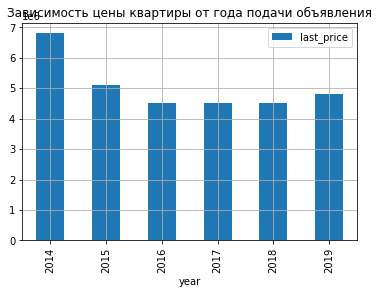

In [ ]:
good_data.pivot_table(index='year', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от года подачи объявления')

А вот по годам картина интереснее. В 2014 году цены на жильё были заметно выше (средняя цена была 7,5 миллионов), чем в последующие годы. Вероятно это связано с уже упоминаемым обвалом рубля в конце 2014 года, и люди стали не способны платить прежнюю цену. В 2016-2017 года средняя цена была самой низкой - 4,5 миллиона. После этого наблюдается постепенный рост цен на недвижимость.

Сравним как меняется цена квартиры в зависимости от населённого пункта. Составим сводную таблицу из названия населённого пункта и цены за квадратный метр и найдём медианную цену и количество объявлений в каждом пункте.

In [ ]:
locations = good_data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['median', 'count'])
locations.columns = ['price', 'count']
locations.sort_values(by='count', ascending=False).head(11)

,price,count
locality_name,,
Санкт-Петербург,102827.763496,13439
посёлок Мурино,84381.592827,488
посёлок Шушары,75949.367089,403
Всеволожск,65789.473684,333
Колпино,73913.043478,307
Пушкин,97938.144330,303
посёлок Парголово,91428.571429,297
деревня Кудрово,91618.217054,282
Гатчина,67180.706522,268


Ожидаемо, больше всего объявлений по Санкт-Петербургу. Выберем топ 10 населённых пунктов по количеству объявлений и сохраним всё это в новую таблицу *top_locations*.

In [ ]:
locations = locations.query('count > 200')

In [ ]:
top_locations = good_data.query('locality_name in @locations.index')
top_locations

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total,cityCenters_nearest_group
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81,82920.792079,1,12,2018,первый,0.460396,0.272277,"(10000, 20000]"
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214,"(10000, 20000]"
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN,"(5000, 10000]"
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000,"(5000, 10000]"
6,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.6,6,NaN,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155,99195.710456,3,11,2017,другой,0.284182,0.386059,"(10000, 20000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9200000.0,101.00,2019-04-01,3,3.05,15,63.0,12,NaN,False,False,15.0,0,Санкт-Петербург,15632.0,14428.0,0,NaN,0,NaN,23,91089.108911,0,4,2019,другой,0.623762,0.148515,"(10000, 20000]"
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15,16.3,4,NaN,False,False,9.1,2,Санкт-Петербург,17284.0,16081.0,1,353.0,2,652.0,29,100566.572238,2,2,2018,другой,0.461756,0.257790,"(10000, 20000]"
23690,3,5500000.0,52.00,2018-07-19,2,NaN,5,31.0,2,NaN,False,False,6.0,0,Санкт-Петербург,20151.0,6263.0,1,300.0,0,NaN,15,105769.230769,3,7,2018,другой,0.596154,0.115385,"(5000, 10000]"
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,NaN,False,False,10.6,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519,129903.978052,3,10,2016,другой,0.552812,0.145405,"(2000, 5000]"


Теперь посмотрим какая средняя цена за квадратный метр в выбранных населённых пунктах.

In [ ]:
top_locations.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['median', 'count'])

,median,count
,price_per_meter,price_per_meter
locality_name,,
Всеволожск,65789.473684,333
Выборг,56960.594315,208
Гатчина,67180.706522,268
Колпино,73913.043478,307
Пушкин,97938.144330,303
Санкт-Петербург,102827.763496,13439
деревня Кудрово,91618.217054,282
посёлок Мурино,84381.592827,488


Text(0.5, 1.0, 'Средняя цена за квадратный метр по населённым пунктам')

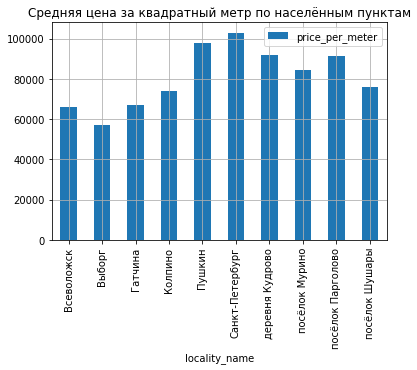

In [ ]:
top_locations.pivot_table(index='locality_name', values='price_per_meter', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Средняя цена за квадратный метр по населённым пунктам')

В Санкт-Петербурге самая высокая цена за квадратный метр, в среднем там предлагают платить более 100 тысяч за квадратный метр. Не отстаёт и пригород: в Пушкине средний ценник 100 тысяч ровно, а в Кудрово, Мурино и Парголово - от 80 до 95 тысяч. Меньше всего квадратный метр стоит в Выборге - 58 тысяч, не удивительно, ведь он находится в 140 километрах от Санкт-Петербурга.

# Вывод

Мы рассмотрели ряд факторов, которые могут влиять на стоимость жилья. По итогу можно сказать, что в Санкт-Петербурге цена на жильё выше, чем в области, при чём порой в несколько раз. Напрямую на стоимость квартиры влияют площадь и количество комнат, чем больше один из показателей, тем выше цена за недвижимость. Обратное влияние оказывает удалённость от центра города, чем дальше, тем цена ниже. Квартиры на другом этаже продаются чаще и стоят дороже, чем квартиры на первом или последнем этажах. А вот день и месяц не оказывают никакого влияние на цену в объявлениях. Есть определённая зависимость от года подачи объявления, но связана она скорее с экономическими потрясениями.

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Отличные и логичные выводы, даже добавить нечего 😊
    
</div>

### Какова стоимость жилья в центре Санкт-Петербурга?

Постараемся найти центр Санкт-Петербурга и узнать сколько там стоит жильё. Для начала выделим в новый датафрейм все объявления, относящиеся к городу.

In [ ]:
good_data_spb = good_data.query('locality_name == "Санкт-Петербург"').copy()
good_data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total,cityCenters_nearest_group
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214,"(10000, 20000]"
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN,"(5000, 10000]"
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000,"(5000, 10000]"
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,NaN,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289,88524.590164,6,2,2017,другой,0.714754,0.106557,"(10000, 20000]"
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,NaN,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137,127525.252525,3,11,2017,другой,0.512626,0.214646,"(10000, 20000]"


Создадим новый столбец, куда сохраним расстояние до центра в километрах, округлённое до целых значений.

In [ ]:
good_data_spb['cityCenters_nearest_km'] = good_data_spb['cityCenters_nearest']/1000

In [ ]:
good_data_spb['cityCenters_nearest_km'] = good_data_spb['cityCenters_nearest_km'].round().astype('Int64')
good_data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total,cityCenters_nearest_group,cityCenters_nearest_km
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558,92785.714286,3,8,2015,другой,0.612500,0.148214,"(10000, 20000]",14
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN,"(5000, 10000]",7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000,"(5000, 10000]",8
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,NaN,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289,88524.590164,6,2,2017,другой,0.714754,0.106557,"(10000, 20000]",15
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,NaN,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137,127525.252525,3,11,2017,другой,0.512626,0.214646,"(10000, 20000]",14


Посчитаем среднюю цену для каждого километра.

In [ ]:
good_data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['median', 'count'])

,median,count
,last_price,last_price
cityCenters_nearest_km,,
0,12500000.0,18
1,10770000.0,159
2,9550000.0,250
3,8000000.0,271
4,8669500.0,568
5,8900000.0,753
6,8500000.0,508
7,7300000.0,344


Text(0.5, 1.0, 'Зависимость цены квартиры в СПб от удалённости от центра\n')

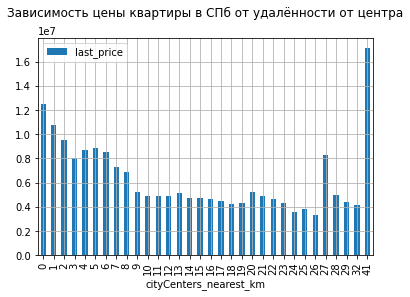

In [ ]:
good_data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры в СПб от удалённости от центра\n')

По графику видно, что есть несколько пиков: в зоне до километра от центра, в удалении 27 километров и 41 километр. Если первый пик вполне логичен, то вот остальые выглядят аномально, однако они нас не интересуют. Мы видим группу значений в районе до 8 километров включительно, после которой идёт резкое падение на графике и наблюдается стагнация стоимости жилья. Величина этого падения почти 2 миллиона.

# Вывод
Мы можем утверждать, что в Санкт-Петербурге центральной частью города является зона в пределах восьми километров от центра.

### Какие факторы влияют на стоимость жилья в центре Санкт-Петербурга и как они отличаются от значений по всему городу?

Выделим все объявления по центру города и сохраним их в новую таблицу.

In [ ]:
good_data_spb_center = good_data_spb[good_data_spb['cityCenters_nearest_km']<= 8].copy()
good_data_spb_center.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday,month,year,floor_group,living_area_to_total,kitchen_area_to_total,cityCenters_nearest_group,cityCenters_nearest_km
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424,408176.100629,4,7,2015,другой,NaN,NaN,"(5000, 10000]",7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.000000,1,6,2018,другой,0.320000,0.410000,"(5000, 10000]",8
24,8,6500000.0,97.2,2015-10-31,2,NaN,3,46.5,1,NaN,False,False,19.6,0,Санкт-Петербург,20052.0,2336.0,3,411.0,3,124.0,265,66872.427984,5,10,2015,первый,0.478395,0.201646,"(2000, 5000]",2
35,6,15500000.0,149.0,2017-06-26,5,NaN,5,104.0,4,NaN,False,False,17.0,0,Санкт-Петербург,23670.0,3502.0,0,NaN,1,779.0,644,104026.845638,0,6,2017,другой,0.697987,0.114094,"(2000, 5000]",4
51,7,45000000.0,161.0,2017-10-17,3,3.20,8,38.0,4,NaN,False,False,50.0,0,Санкт-Петербург,32537.0,6589.0,0,NaN,3,99.0,541,279503.105590,1,10,2017,другой,0.236025,0.310559,"(5000, 10000]",7


Посмотрим каково распределение цены на квартуру в центре Петербурга, построим гистограмму.

Text(0.5, 1.0, 'Гистограмма распределения цен на жильё в центре Санкт-Петербурга')

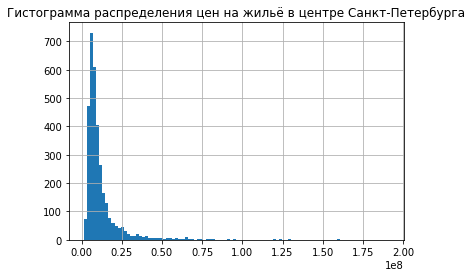

In [ ]:
good_data_spb_center.hist(column='last_price', grid=True, bins=100)
plt.title('Гистограмма распределения цен на жильё в центре Санкт-Петербурга')

In [ ]:
good_data_spb_center['last_price'].describe()

count    3.372000e+03
mean     1.264338e+07
std      1.519824e+07
min      1.600000e+06
25%      6.200000e+06
50%      8.500000e+06
75%      1.280000e+07
max      1.908700e+08
Name: last_price, dtype: float64

Средняя стоимость квартиры около 13 миллионов, что совпадает с третьим квартилем, а медиана равна 8,9 млн. Это значит, что максимальные значения сильно тянут среднее вверх. Максимально же за квартиру в центре просят 191 миллион. Сравним эти цифры с данными по всему городу.

Text(0.5, 1.0, 'Гистограмма распределения цен на жильё в Санкт-Петербурге')

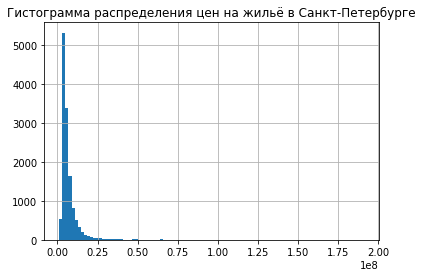

In [ ]:
good_data_spb.hist(column='last_price', grid=True, bins=100)
plt.title('Гистограмма распределения цен на жильё в Санкт-Петербурге')

In [ ]:
good_data_spb['last_price'].describe()

count    1.343900e+04
mean     7.409006e+06
std      8.717280e+06
min      1.190000e+06
25%      4.100000e+06
50%      5.300000e+06
75%      7.679000e+06
max      1.908700e+08
Name: last_price, dtype: float64

В сравнении с центром средняя цена по городу упала вдвое, да и медианное значение уменьшилось почти на 3,5 миллиона. Сгладил цифры тот фактор, что в целом по городу объявлений почти в 4 раза больше, а цена на жильё за пределами центра ниже.

Посмотрим, какие в центре города площади квартир.

Text(0.5, 1.0, 'Гистограмма распределения площади жилья в центре Санкт-Петербурга')

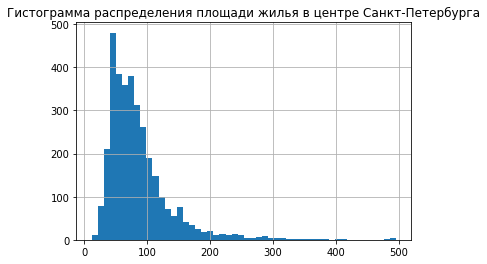

In [ ]:
good_data_spb_center.hist(column='total_area', grid=True, bins=50)
plt.title('Гистограмма распределения площади жилья в центре Санкт-Петербурга')

In [ ]:
good_data_spb_center['total_area'].describe()

count    3372.000000
mean       85.824843
std        51.097668
min        12.000000
25%        52.575000
50%        73.425000
75%       100.600000
max       495.000000
Name: total_area, dtype: float64

На графике мы видим, что у нас есть два пика, первый говорит нам о том, что в центре больше всего квартир с площадью около 40 квадратных метров, а вторые по распространённости квартиры с площадью под 70 квадратных метров. Видимо это двух- и трехкомнатные квартиры. Среднее значение по центру 88,5 квадратов при медианном значении в 76, а три четверти квартир имеют площадь до 106 квадратов. Сравним с площадью по городу в целом.

Text(0.5, 1.0, 'Гистограмма распределения площади жилья в Санкт-Петербурге')

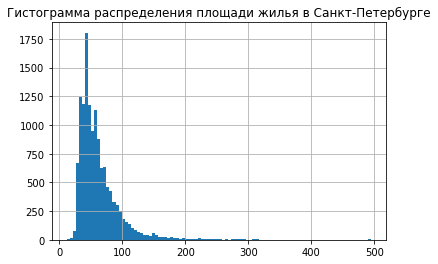

In [ ]:
good_data_spb.hist(column='total_area', grid=True, bins=100)
plt.title('Гистограмма распределения площади жилья в Санкт-Петербурге')

In [ ]:
good_data_spb['total_area'].describe()

count    13439.000000
mean        62.457452
std         35.687126
min         12.000000
25%         41.300000
50%         53.900000
75%         72.000000
max        495.000000
Name: total_area, dtype: float64

По городу в целом мы видим, что квартир с площадью около 40 метров стало ещё больше. График распределения похож на график по центру города, но тут выделяется ещё один пик в районе 25-30. Площади в целом стали поменьше, среднее и медиана стали меньше на 20 квадратных метров.

Взглянем теперь как распределено число комнат в квартирах по центру города и как оно отличается от общегородских.

Text(0.5, 1.0, 'Гистограмма распределения количества комнат в центре Санкт-Петербурга')

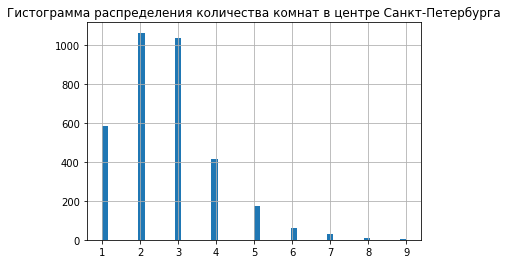

In [ ]:
good_data_spb_center.hist(column='rooms', grid=True, bins=50)
plt.title('Гистограмма распределения количества комнат в центре Санкт-Петербурга')

In [ ]:
good_data_spb_center['rooms'].describe()

count    3372.000000
mean        2.671708
std         1.276581
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         9.000000
Name: rooms, dtype: float64

Центре у нас явно выделяются двух- и трёх комнатные квартиры, их количество примерно одинаково, далее идут однушки. Явных отклонений тут не наблюдается, что среднее, что медиана почти равны и совпадают с третьи квартилем. Максимальное количество комнат в центре - 9. Сравним с общегородскими значениями.

Text(0.5, 1.0, 'Гистограмма распределения количества комнат в Санкт-Петербурге')

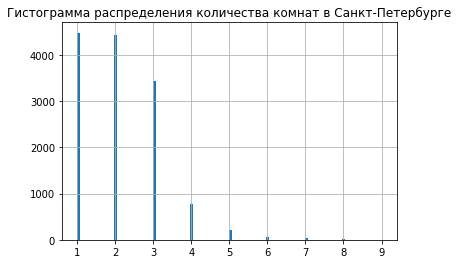

In [ ]:
good_data_spb.hist(column='rooms', grid=True, bins=100)
plt.title('Гистограмма распределения количества комнат в Санкт-Петербурге')

In [ ]:
good_data_spb['rooms'].describe()

count    13439.000000
mean         2.123596
std          1.063321
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64

По городу же преобладают одно- и двухкомнатные квартиры, трёшек меньше почти на тысячу. По этой причине среднее и медина уменьшились на одну комнату. 

А что с высотой потолков, есть ли различия? Посмотрим на потолки в центре, выбрав наиболее релевантный диапазон до 5 метров.

Text(0.5, 1.0, 'Гистограмма распределения высоты потолков в центре Санкт-Петербурга')

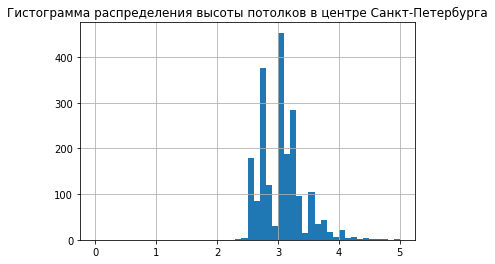

In [ ]:
good_data_spb_center.hist(column='ceiling_height', grid=True, bins=50, range=(0,5))
plt.title('Гистограмма распределения высоты потолков в центре Санкт-Петербурга')

In [ ]:
good_data_spb_center['ceiling_height'].describe()

count    2089.000000
mean        3.074873
std         0.923393
min         2.400000
25%         2.800000
50%         3.000000
75%         3.200000
max        27.000000
Name: ceiling_height, dtype: float64

Как мы отмечали ранее зависимости в данных с высотой потолков нет, поэтому график выгляди хаотично. Мы можем отметить, что центре преобладают кватиры с высотой потолков 3 метра, далее 2,7 и 3,2 метра. В среднем высота потолков по центральному району 3,1 метра, что очень близко к медианному.

Text(0.5, 1.0, 'Гистограмма распределения высоты потолков в Санкт-Петербурге')

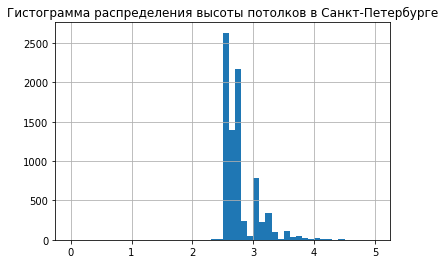

In [ ]:
good_data_spb.hist(column='ceiling_height', grid=True, bins=50, range=(0,5))
plt.title('Гистограмма распределения высоты потолков в Санкт-Петербурге')

In [ ]:
good_data_spb['ceiling_height'].describe()

count    8263.000000
mean        2.780685
std         0.829605
min         2.000000
25%         2.550000
50%         2.700000
75%         2.800000
max        27.500000
Name: ceiling_height, dtype: float64

По Санкт-Петербургу же ситуация иная. Самое распространённое жильё в городе имеет высоту потолков в 2,5 метра, вторые по распространённости потолки в 2,7 метра, далее - 3 метра. Средняя высота потолков по Петербургу 2,8 метра, что близко к медиане в 2,7 метра.

#### Промежуточный итог
Подводя итог сравнению показателей квартир по городу в целом и по центру города в частности мы можем сказть, что жильё в центре больше по площади и дороже. Также в центре в среднем на одну комнату больше, а потолки выше.

Узнаем, что и как влияет на стоимость квартир в центре и как оно отличется от общегородских значений. Посмотрим как влияет число комнат.

Text(0.5, 1.0, 'Зависимость цены квартиры от количества комнат\n')

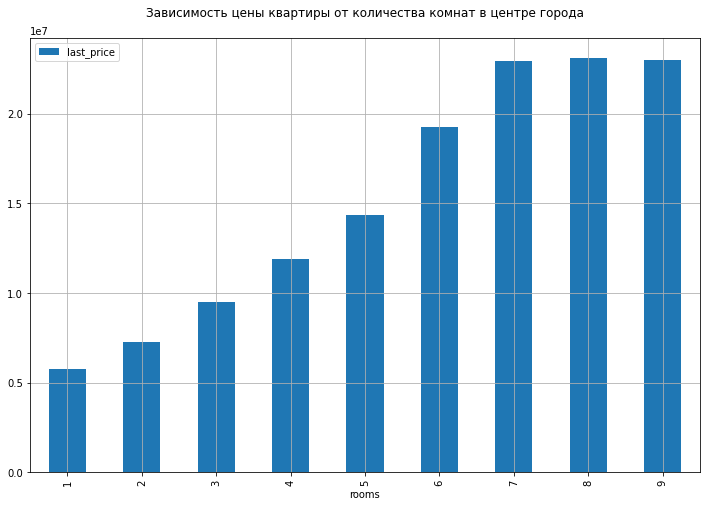

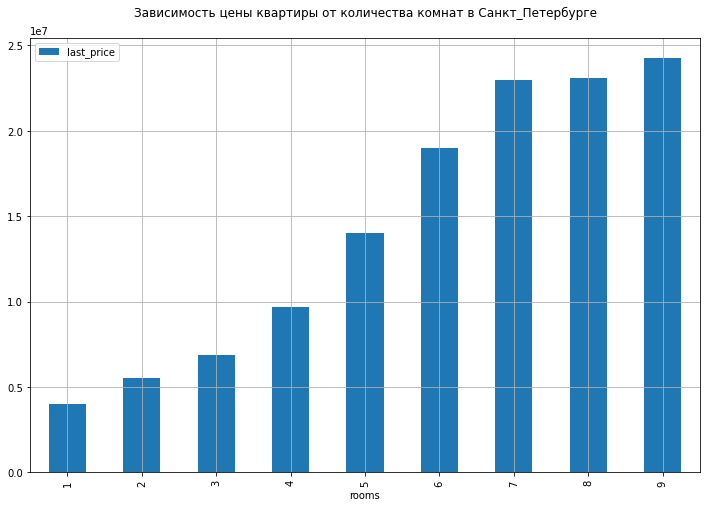

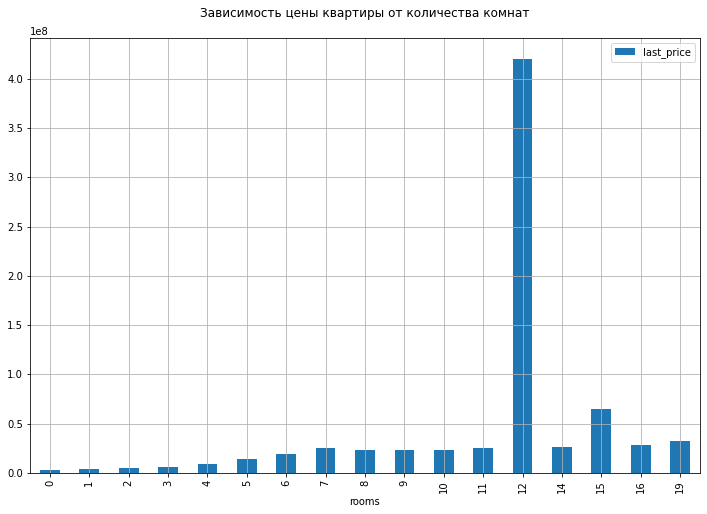

In [ ]:
good_data_spb_center.pivot_table(index='rooms', values='last_price', aggfunc='median')\
.plot(kind='bar', grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от количества комнат в центре города\n')

good_data_spb.pivot_table(index='rooms', values='last_price', aggfunc='median')\
.plot(kind='bar', grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от количества комнат в Санкт_Петербурге\n')

data.pivot_table(index='rooms', values='last_price', aggfunc='median')\
.plot(kind='bar', grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от количества комнат\n')

Что по центру города, что по Петербургу в целом, между количеством комнат и ценой за квартиру наблюдается прямая зависимость, чем больше комнат, тем выше цена. На общем графике тоже видна эта зависимость, но всё портят квартиры с числом комнат 12 и 15.  Посмотрим на зависимость цены от этажа.

Text(0.5, 1.0, 'Зависимость цены квартиры от этажа')

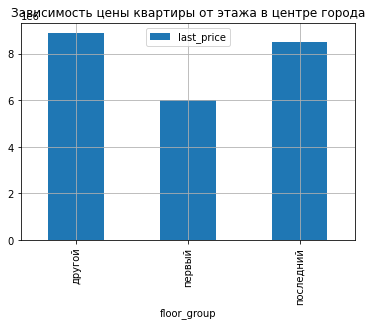

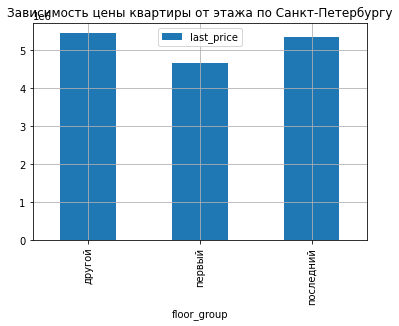

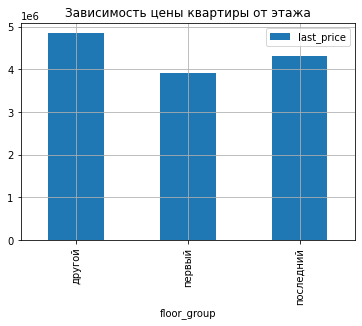

In [ ]:
good_data_spb_center.pivot_table(index='floor_group', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа в центре города')

good_data_spb.pivot_table(index='floor_group', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа по Санкт-Петербургу')

data.pivot_table(index='floor_group', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа')

В центре города разница в том что цена на квартиры на первых этажах ниже заметнее, чем во всём городе. В центре первые этажи чаще покупают для коммерческих целей, чем для жилых, а люди не хотят покупать жильё, если знают, что рядом какой-нибудь магазин и постоянно шумно. Другой и последний этажи примерно равны по средней стоимости квартиры, что отличается от нашего первого вывода зависимости цены от этажа, поскольку там было заметно, что жильё на последнем этаже, дешевле, чем на другом.
Посмотрим на зависимость цены от удалённости от центра.

Text(0.5, 1.0, 'Зависимость цены квартиры от удалённости от центра по Санкт-Петербургу\n')

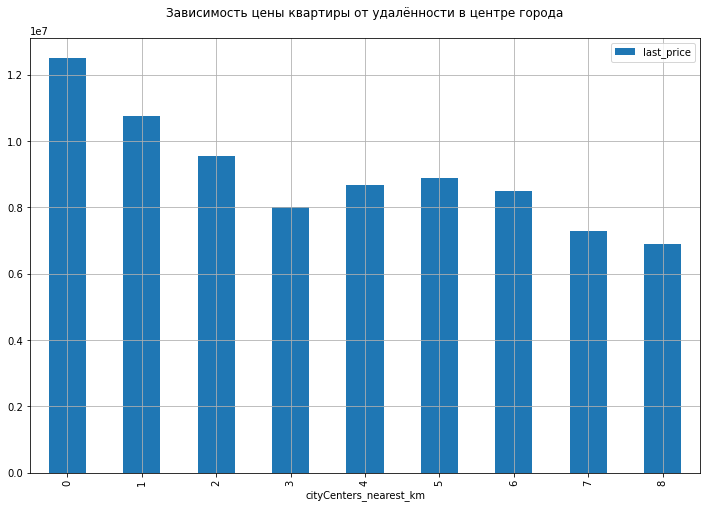

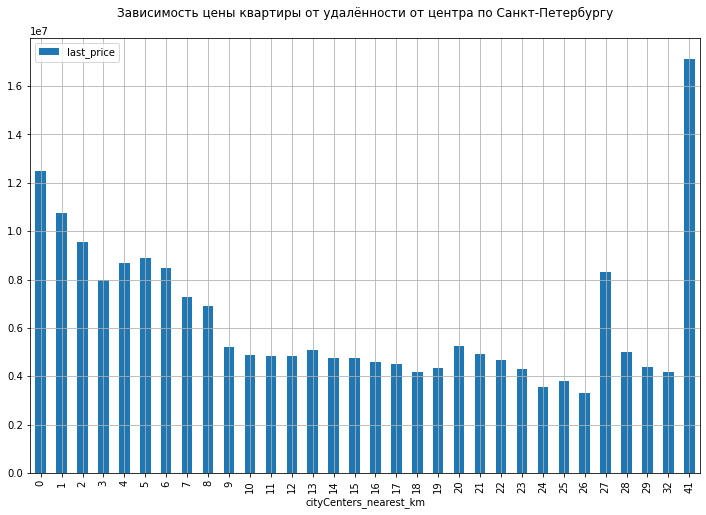

In [ ]:
good_data_spb_center.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median')\
.plot(kind='bar', grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от удалённости в центре города\n')

good_data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median')\
.plot(kind='bar', grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от удалённости от центра по Санкт-Петербургу\n')

Что по центру города, что по всему городу зависимость цены от удалённости не равномерна. Прослеживается общая тенденция на уменьшение цены с увеличением удалённости, но есть пики на всей протяжённости. Вероятно это говорит, что там могут оказывать влияние другие факторы.
Посмотрим влияет ли дата размещения на цену.

Text(0.5, 1.0, 'Зависимость цены квартиры от даты размещения')

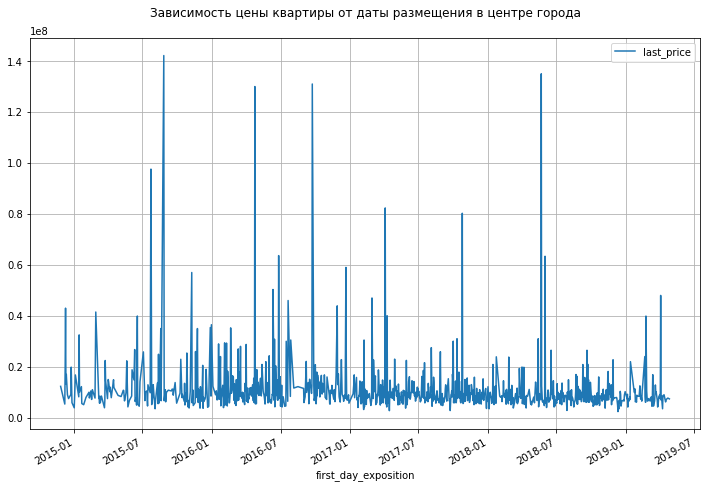

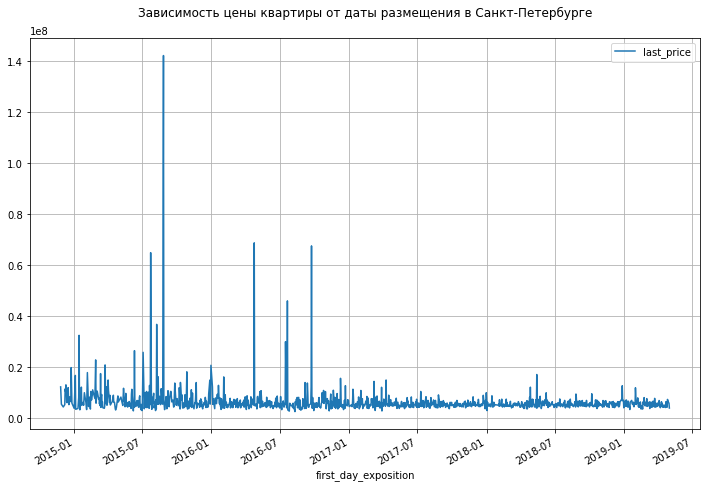

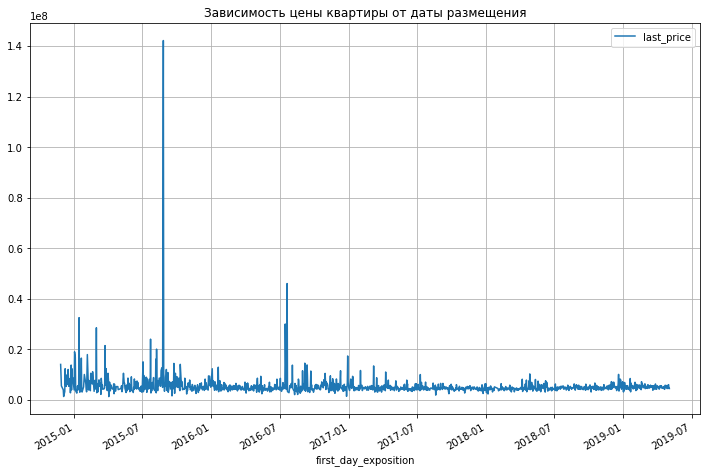

In [ ]:
good_data_spb_center.pivot_table(index='first_day_exposition', values='last_price', aggfunc='median')\
.plot(grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от даты размещения в центре города\n')

good_data_spb.pivot_table(index='first_day_exposition', values='last_price', aggfunc='median')\
.plot(grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от даты размещения в Санкт-Петербурге\n')

data.pivot_table(index='first_day_exposition', values='last_price', aggfunc='median')\
.plot(grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от даты размещения')

Дата размещения никак не влияет на цену жилья. Графики показывают, что цена на квартиру распределена равромерно, а пики располагаются хаотично.

# Вывод 
Жильё в центре больше по площади и дороже, а также в среднем на одну комнату больше, а потолки выше, чем в целом по городу. Количество комнат одинаково влияет на стоимость жилья, что в центре, что по Петербургу, как и удалённость от центра, хотя корреляция в этом случае заметно ниже. Квартиры на первом этаже стоят дешевле, чем на остальных, только в центре разница в ценах заметнее. А вот дата вообще никак не влияет на ценообразование.

### Шаг 5. Общий вывод

Подводя итог исследованию мы можем сказать, что средняя цена на квартиры колеблется от 4,5 до 9 миллионов в центре города, на это напрямую влияют площадь и количество комнат, и удалённость от центра города. Средняя площадь по городу около 60 квадратных метров, а среднее количество комнат -две. Косвенное влияние оказывают высота потолков и этаж. Преимущественно по городу выставляют на продажу квартиры с высотой потолков 2,8 метра, которые располагаются не на первом и не на последнем этажах. Дата подачи объявления никак не влияет на цену, ни день, ни месяц. 
Бывают исключения, но они довольно редкие. Например, квартира с высотой потолков в 3 метра может стоить дешевле аналогичной, но с высотой потолков в 2,5 метра. Это может значить, что либо есть другие не известные нам факторы, которые могут влиять на образование цен на недвижимость, либо мы столкнулись с аномалией. Если при стандартных факторах цена будет сильно ниже от средней, значит перед нами, скорее всего, мошенническое объявление.

Text(0.5, 1.0, 'Зависимость цены квартиры от даты размещения')

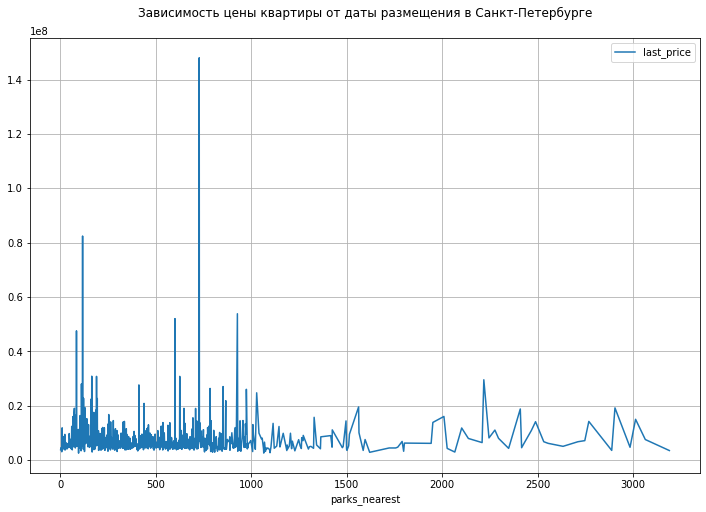

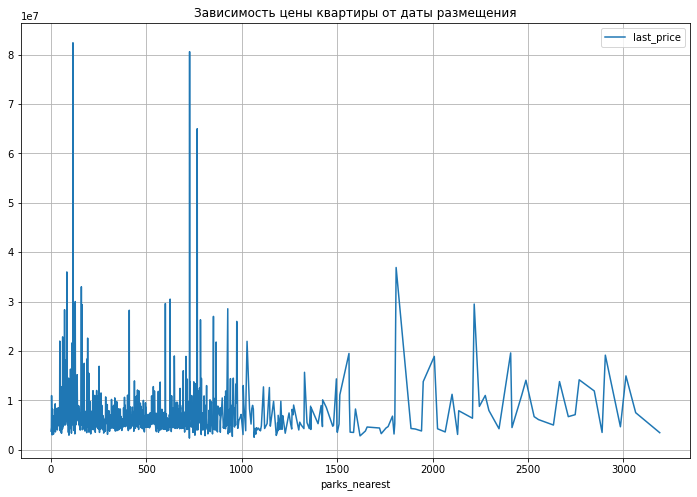

In [ ]:
good_data_spb.pivot_table(index='parks_nearest', values='last_price', aggfunc='median')\
.plot(grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от даты размещения в Санкт-Петербурге\n')

data.pivot_table(index='parks_nearest', values='last_price', aggfunc='median')\
.plot(grid=True, figsize=(12,8))
plt.title('Зависимость цены квартиры от даты размещения')

Text(0.5, 1.0, 'Зависимость цены квартиры от этажа')

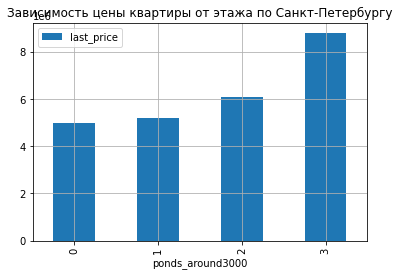

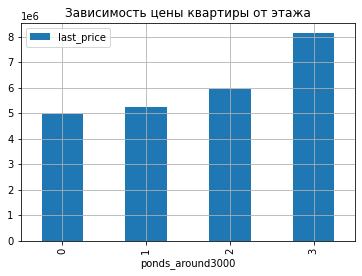

In [ ]:
good_data_spb.pivot_table(index='ponds_around3000', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа по Санкт-Петербургу')

data.pivot_table(index='ponds_around3000', values='last_price', aggfunc='median').plot(kind='bar', grid=True)
plt.title('Зависимость цены квартиры от этажа')